<a href="https://colab.research.google.com/github/zshureih/Step-Forward-Training/blob/main/Step_Forward_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing requirements

In [ ]:
!pip install phyre matplotlib tqdm ipywidgets
!pip install -U -q Pillow moviepy proglog

In [ ]:
import phyre
import numpy as np

import os.path
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from PIL import Image

import matplotlib.pyplot as plt

# Function to Build a Dataset

In [ ]:
import os.path
import phyre
import numpy as np

def convert_to_rgb(object_vec):
    rasters = [phyre.featurized_objects_vector_to_raster(o) for o in object_vec]
    rgb_images = [255*phyre.observations_to_float_rgb(r) for r in rasters]
    return rgb_images

def get_fold(eval_setup, fold_id):
    train_tasks, val_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
    return train_tasks, val_tasks, test_tasks

def make_simulator(tasks, action_tier='ball'):
    # task = phyre.loader.load_task_script(task_path)
    # template_id, _, module = task
    # task_dict = {task.taskId: task for task in module.build_task(template_id)}
    # simulator = phyre.action_simulator.ActionSimulator(task_dict, action_tier)
    simulator = phyre.initialize_simulator(tasks, action_tier)
    return simulator

def get_default_actions():
  default_actions = np.stack([np.random.rand(100)*.6 + 0.2, # ball x
                              np.random.rand(100)*.3 + 0.5, # ball y
                              np.random.rand(100)*.2 + 0.6]).T # ball r
  return default_actions

def sample_trajectories(simulator, stop_sim_at=20, max_actions=1000, actions=None, use_tqdm=False):
  actions = simulator.build_discrete_action_space(max_actions) if actions is None else actions

  if use_tqdm:
    from tqdm import tqdm_notebook
    fn = lambda rng: tqdm_notebook(rng, desc='Simulate tasks')
  else:
    fn = lambda rng: rng

  feature_trajs, pixel_trajs = [], []
  for task_index in fn(range(len(simulator.task_ids))):
    x = np.random.randint(0,len(actions))
    action = actions[x] # choose a random action
    
    simulation = simulator.simulate_action(task_index, action=action,
                                          need_images=True, stride=15,
                                          need_featurized_objects=True)
    
    # if simulation input is invalid, keep grabbing actions until it isn't
    while simulation.status is phyre.SimulationStatus.INVALID_INPUT:
      x = np.random.randint(0,len(actions))
      action = actions[x] # choose a random action
      
      simulation = simulator.simulate_action(task_index, action=action,
                                          need_images=True, stride=15,
                                          need_featurized_objects=True)
    
    # if we have a valid simulation
    if simulation.status is not phyre.SimulationStatus.INVALID_INPUT:
      # get features and simulation images
      t = simulation.featurized_objects.features[:stop_sim_at]
      # print(t.shape)
      imgs = simulation.images[:stop_sim_at]
      rgb_images = [255*phyre.observations_to_float_rgb(img) for img in imgs]

      # we are just looking for movement, not whether the action succeeds
      # if t.shape[0] == 40: 
      feature_trajs.append(t)
      pixel_trajs.append(rgb_images)
  
  return feature_trajs, pixel_trajs

def get_dataset(simulator, seed=0, test_split=0.8, **kwargs):
  # data = {'meta': locals()}

  # collect some trajectories via Phyre
  np.random.seed(seed)
  trajectories, pixels = sample_trajectories(simulator, **kwargs)
  # permute the order of the tasks
  # ixperm = np.random.permutation(trajectories.shape[0])
  # trajectories = trajectories[ixperm] # shuffle the trajectories
  # pixels = pixels[ixperm]
  
  return trajectories, pixels

# Utility Functions

In [ ]:
def _update_inputs(features, inputs):
    inputs = np.concatenate([features[...,:2], features[...,3:4]], axis=-1)
    inputs = inputs.reshape(*inputs.shape[:2], -1)
    return features, inputs

def _update_features(features, inputs):
    # z = np.zeros([*y.shape[:2],3,14])
    v = inputs.reshape([*inputs.shape[:2],3,3])
    features[...,:2] = v[...,:2]
    features[...,3:4] = v[...,2:3]
    return features, inputs

def _update(update_fn, data):
    if type(data) is dict:
        result = {}
        var_names = ['x', 'y', 'dx']
        var_names += ['test_' + k for k in var_names]
        for k in var_names: # var
            feat_k, input_k = update_fn(data['feat_' + k], data[k])
            result[k] = input_k
            result['feat_' + k] = feat_k
    else:
        result = update_fn(*data)
    return result

update_inputs = lambda data: _update(_update_inputs, data)
update_features = lambda data: _update(_update_features, data)

# Make a dataset

In [ ]:
# task_path = './custom_tasks/task_z_0.py'
# write_custom_task(task_path)
train_tasks, val_tasks, test_tasks = get_fold('ball_cross_template', 0)
print("# of Train Tasks: {}\n# of Val Tasks: {}\n# of Test Tasks: {}".format(len(train_tasks), len(val_tasks), len(test_tasks)))

# shuffle training tasks
indices = np.random.permutation(len(train_tasks))
train_tasks = np.array(train_tasks)[indices]

# make a simulator
simulator = make_simulator(train_tasks[:50])

features, pixels = get_dataset(simulator)
print("len of features stack",len(features))
print("len of pixels stack", len(pixels))


# of Train Tasks: 1600
# of Val Tasks: 400
# of Test Tasks: 500
len of features stack 50
len of pixels stack 50


# Exploring a Feature

phyre.FeaturizedObjects = TxNx14 np.array where T is the number of timesteps, N is the number of objects in the scene and 14 is the feature vector size. The features are by index:

In [ ]:
print("Features Shape:", features[0].shape) #featurized object vector
obj_vec = features[0]
print("Timesteps: ", obj_vec.shape[0])
print("Objects: ", obj_vec.shape[1])
print("Object Feature Count: ", obj_vec.shape[2])

Features Shape: (20, 7, 14)
Timesteps:  20
Objects:  7
Object Feature Count:  14


# Render Replay

In [ ]:
idx = np.random.randint(len(features))
rgb_images = convert_to_rgb(features[idx])
ImageSequenceClip(rgb_images, fps=20).ipython_display()

t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
idx = np.random.randint(len(pixels))
images = [p for p in pixels[idx]]
ImageSequenceClip(images, fps=20).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Pixel Based Models
Extract world state with an image encoder

Encoder e is a ResNet-18 network clipped at res4 block

7 channels with binary values that indicate object presence

Representations from the past t frames are concatenated before being input into the dynamics model

In [ ]:
import torch

# Object Based Models

Interaction Network - ([INT](https://github.com/higgsfield/interaction_network_pytorch/blob/master/Interaction%20Network.ipynb))

*   Maintain a vector representation for each object in the system at time *t*
*   Vector contains information about object type, position and velocity
*   Relationship is computed for each ordered pair of objects
    * First object is sender
    * Second object is receiver of the relation
*   Model embeds the relations into "effects" per object using MLP (multi-layer preceptron)
*   Effects are subbed into a single effect per object, concatenated with object's previous state vector along with a placeholder for external effects (e.g. gravity)
*   Result is passed through another MLP to predict velocity of the object
  



In [ ]:
import os, random, time
random.seed(time.clock())

import numpy as np
np.random.seed(int(time.clock()))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

USE_CUDA = False

In [ ]:
def get_batch(data, batch_size):
    rand_idx  = [random.randint(0, len(data) - 2) for _ in range(batch_size)]
    label_idx = [idx + 1 for idx in rand_idx]
    print(rand_idx)
    batch_data = data[rand_idx]
    label_data = data[label_idx]
    # print(label_data.shape)
    # print(batch_data.shape)
    objects = batch_data[:,:]
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    n_objects = objects.shape[1]
    n_relations = n_objects * (n_objects-1)
    relation_dim = 1
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    # This could be the spot to hard-code color based rules
    # just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data[:,:,:2] #label data is x,y and theta position, so we predict the new position
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target)).reshape(-1, 2)
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target

In [ ]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [ ]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2), # x, y
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] x and y
        '''
        input_size = x.size(2)
        x = x.view(-1, input_size)
        return self.layers(x)

In [ ]:
class InteractionNetwork(nn.Module):
    def __init__(self, object_dim, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel(object_dim + effect_dim, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [ ]:
object_dim = obj_vec.shape[2]
relation_dim = 1

interaction_network = InteractionNetwork(object_dim, relation_dim, 100)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.MSELoss()


In [ ]:
# objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[0], 1)

# print("#objects shape", objects.shape)
# print("#target shape", target.shape)
# print("#object positions", objects[0,:,:2])
# print("#target", target)
# predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
# print("#predicted shape", target.shape)
# print("#predicted", predicted)

# rgb_images = convert_to_rgb(features[0])
# ImageSequenceClip(rgb_images, fps=20).ipython_display()

# Training

In [ ]:
# losses = []

# for i in range(1, 101): #epochs
#     # grab 16 tasks at a time
#     x = (i-1)*16
#     y = i*16

#     # make a simulator
#     simulator = make_simulator(train_tasks[x:y])
#     features, pixels = get_dataset(simulator)

#     val_loss = 0
#     for j in range(len(features)): # for action/replay
#       objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[j], 30)
#       # print("#objects shape", objects.shape)
#       # print("#sender_relations shape", sender_relations.shape)
#       # print("#receiver_relations shape", receiver_relations.shape)
#       # print("#relation_info shape", relation_info.shape)
#       # print("#target shape", target.shape)
#       predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
#       # print(predicted[0])
#       # print(predicted.shape)
#       loss = criterion(predicted, target)
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#       losses.append(np.sqrt(loss.item()))

#     clear_output(True)
#     plt.figure(figsize=(20,5))
#     plt.subplot(131)
#     plt.title('Epoch %s RMS Error %s' % (i, np.sqrt(np.mean(losses[-10:]))))
#     plt.plot(losses)
#     plt.show()


# "Hard-coded" Training

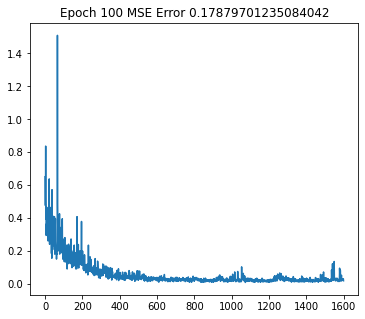

In [ ]:
losses = []

for i in range(1, 101): #epochs
    # grab a random 16 tasks at a time
    r = random.randint(1,100)
    x = (r-1)*16
    y = r*16

    # make a simulator
    simulator = make_simulator(train_tasks[x:y])
    features, pixels = get_dataset(simulator)

    val_loss = 0
    for j in range(len(features)): # for action/replay
      objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[j], 10)
      # print("#objects shape", objects.shape)
      # print("#sender_relations shape", sender_relations.shape)
      # print("#receiver_relations shape", receiver_relations.shape)
      # print("#relation_info shape", relation_info.shape)
      # print("#target shape", target.shape)
      predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
      # print(predicted.shape)

      for k in range(len(objects[0])): #for each object in the replay
        if objects[0][k][13] == 1 or objects[0][k][11] == 1: # if the object is black or purple i.e. is immovable
          predicted[k] = target[k] # set prediction to target value
        
      loss = criterion(predicted, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(np.sqrt(loss.item()))

    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s MSE Error %s' % (i, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()


# Validation

In [ ]:
# losses = []

# for i in range(1, 101): #epochs
#     # grab 4 tasks at a time
#     r = random.randint(1,100)
#     x = (r-1)*4
#     y = r*4
#     print(x)
#     # make a simulator
#     simulator = make_simulator(val_tasks[x:y])
#     features, pixels = get_dataset(simulator)

#     val_loss = 0
#     for j in range(len(features)): #this should be actions
#       objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[j], 1)
#       # print("#objects shape", objects.shape)
#       # print("#sender_relations shape", sender_relations.shape)
#       # print("#receiver_relations shape", receiver_relations.shape)
#       # print("#relation_info shape", relation_info.shape)
#       # print("#target shape", target.shape)
#       predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)

#       for k in range(len(objects[0])): #for each object in the replay
#         if objects[0][k][13] == 1 or objects[0][k][11] == 1: # if the object is black or purple i.e. is immovable
#           predicted[k] = target[k] # set prediction to target value

#       # print(predicted[0])
#       # print(predicted.shape)
#       loss = criterion(predicted, target)
#       # optimizer.zero_grad()
#       # loss.backward()
#       # optimizer.step()
#       losses.append(np.sqrt(loss.item()))

#     clear_output(True)
#     plt.figure(figsize=(20,5))
#     plt.subplot(131)
#     plt.title('Epoch %s RMS Error %s' % (i, np.sqrt(np.mean(losses[-100:]))))
#     plt.plot(losses)
#     plt.show()

# Visualizing Predictions

0: x in pixels of center of mass divided by SCENE_WIDTH

1: y in pixels of center of mass divided by SCENE_HEIGHT

2: angle of the object between 0 and 2pi divided by 2pi

3: diameter in pixels of object divided by SCENE_WIDTH

4-8: One hot encoding of the object shape, according to order:
ball, bar, jar, standing sticks

8-14: One hot encoding of object color, according to order:
red, green, blue, purple, gray, black

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def draw_line(image, obj, prediction, color):
  height = len(image)
  width = len(image[0])

  obj_x = int(obj[0] * width)
  obj_y = height - int(obj[1] * height)

  pred_x = int(prediction[0] * width)
  pred_y = height - int(prediction[1] * height)

  # print(obj_y, obj_x)
  # print(image[obj_y][obj_x])
  # print(image[pred_y][pred_x])

  cv2.circle(image, (obj_x, obj_y), 4, color, thickness=-1, lineType=1, shift=0)
  cv2.arrowedLine(image, (obj_x, obj_y), (pred_x, pred_y), color, thickness=2, shift=0)
  return image
  # cv2.imwrite('color_img.jpg', image)
  # cv2.destroyAllWindows()

def draw_lines(frames, objects, prediction):
  print(len(frames))
  image = ''
  images = []
  for i in range(len(frames)): # for each frame
    frame = frames[i] # draw on the frame
    for j in range(len(objects[0])): # draw the start/end arrow for each object in the frame
      obj = objects[0][j]

      # figure out color
      color = ""
      if obj[8]:
        # print("red")
        color = (12, 176, 185)
      if obj[9]:
        # print("green")
        color = (148, 49, 68)
      if obj[10]:
        # print("blue")
        color = (231, 136, 13)
      if obj[11]:
        # print("purple")
        color = (134, 233, 54)
        continue
      if obj[12]:
        # print("gray")
        color = (102, 92, 79)
      if obj[13]:
        # print("black")
        color = (255, 196, 252)
        continue

      # get object location and prediction x,y
      obj_location = obj[:2]
      predicted_location = prediction[j][:2]

      # draw a line from object center to prediction point
      image = draw_line(frame, obj_location, predicted_location, color)
    
    images.append(image)
  return images


In [ ]:
simulator = make_simulator(train_tasks[:50])
features, pixels = get_dataset(simulator)
idx = random.randint(0, len(features) - 1) # get random simulation
objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[idx], 1)
# print("objects", objects.shape)
# print(objects[0,:,:2])
# print(target)
predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
# print(predicted.shape)

loss = criterion(predicted, target)
print(loss)
# for i in range(len(predicted)):
#   print("{} {} {}".format(objects[0,:,:2][i], target[i], predicted[i]))

# # print("target", target)

rgb_images = convert_to_rgb(features[idx])
predicted_images = draw_lines(rgb_images, objects, predicted)
ImageSequenceClip(predicted_images, fps=20).ipython_display(maxduration=90)

[2]
tensor(0.0008, grad_fn=<MseLossBackward>)
20
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Testing

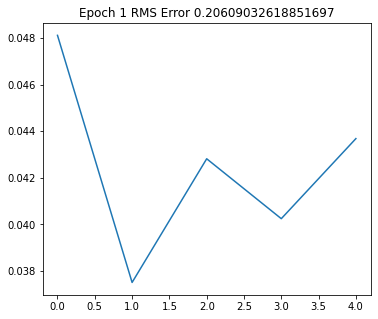

KeyboardInterrupt: ignored

In [ ]:
losses = []

for i in range(1, 101): #epochs
    # grab 4 tasks at a time
    x = (i-1)*5
    y = i*5

    # make a simulator
    simulator = make_simulator(test_tasks[x:y])
    features, pixels = get_dataset(simulator)

    val_loss = 0
    for j in range(len(features)): #this should be actions
      objects, sender_relations, receiver_relations, relation_info, target = get_batch(features[j], 30)
      # print("#objects shape", objects.shape)
      # print("#sender_relations shape", sender_relations.shape)
      # print("#receiver_relations shape", receiver_relations.shape)
      # print("#relation_info shape", relation_info.shape)
      # print("#target shape", target.shape)
      predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
      # print(predicted[0])
      # print(predicted.shape)
      loss = criterion(predicted, target)
      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()
      losses.append(np.sqrt(loss.item()))

    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (i, np.sqrt(np.mean(losses[-10:]))))
    plt.plot(losses)
    plt.show()

# Next Steps

Don't treat it as a black box -- figure out internals of the interaction model

GOOD NEWS - model is object number agnostic. We care about object dimension not number of objects

Autoregressive models are bad

THEORY - model predicts velocity, not state -- I was wrong about that

GOOD NEWS - It doesn't predict final state, I was just drawing the lines wrong... Fix that then talk to Alan.

BAD NEWS - for majority of replay, objects are at rest. Have to talk to Sam about Jumpy NN. Predictions are most important during large amounts of motion. Most predictions are extremely accurate because there's so little movement most of the time